# Y3 Gold classification plots

This notebook is intended to be used to create Y3 Gold paper plots: classification

In [1]:
%matplotlib inline
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#import fitsio
from astropy.io import fits
from astropy.io.fits.hdu.hdulist import HDUList
import healpy as hp
from descolors import BAND_COLORS
import warnings
warnings.filterwarnings('ignore')
workdir = '/Users/nsevilla/y3gold-paper/'
datadir = '/Volumes/NO NAME/'
figsdir = '/Users/nsevilla/y3gold-paper/figs/'

In [57]:
#load Alex's skymap utilities
import skymap
from skymap import Skymap,McBrydeSkymap,OrthoSkymap
from skymap import SurveySkymap,SurveyMcBryde,SurveyOrtho
from skymap import DESSkymap

SKYMAPS = [Skymap,McBrydeSkymap,OrthoSkymap]
SURVEYS = [SurveySkymap,SurveyMcBryde,SurveyOrtho]

NSIDE = 4096
NSIDE_deg = 512

In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 3

In [7]:
import scipy.optimize
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2./(2.*sigma**2))

/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda2/envs/skymap/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


### Stellar map and histogram

In [1]:
# we will use the residual maps from Eli
# https://cdcvs.fnal.gov/redmine/projects/descalibration/wiki/FGCM_Y4A1_Zeropoints#Comparisons-to-Gaia-DR2

In [21]:
Y3_star_map = fits.open(datadir+'stars_sof0_16_23.fits',memmap=True)
Y3_star_data = Y3_star_map[1].data

/anaconda2/envs/skymap/lib/python3.6/site-packages/ipykernel/__main__.py:1: ResourceWarning: unclosed file <_io.FileIO name='/Volumes/NO NAME/stars_sof0_16_23.fits' mode='rb' closefd=True>
  if __name__ == '__main__':


TypeError: bad number of pixels

In [53]:
Y3_star_data_fullsky_nest_4096 = np.full(hp.nside2npix(NSIDE),hp.UNSEEN)

In [54]:
Y3_star_data_fullsky_nest_4096[Y3_star_data['PIXEL']] = Y3_star_data['SIGNAL']
Y3_star_data_fullsky_ring_4096 = hp.reorder(Y3_star_data_fullsky_nest_4096,n2r=True)

In [55]:
Y3_star_data_fullsky = hp.ud_grade(Y3_star_data_fullsky_ring_4096,nside_out=NSIDE_deg,power=-2)

In [56]:
pix, = np.where(Y3_star_data_fullsky != hp.UNSEEN)
mask = Y3_star_data_fullsky != hp.UNSEEN
nstars = Y3_star_data_fullsky[mask]
print(pix)

[1412238 1412274 1412275 ... 3033079 3033080 3033081]


/anaconda2/envs/skymap/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4759: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if fix_wrap_around and itemindex:


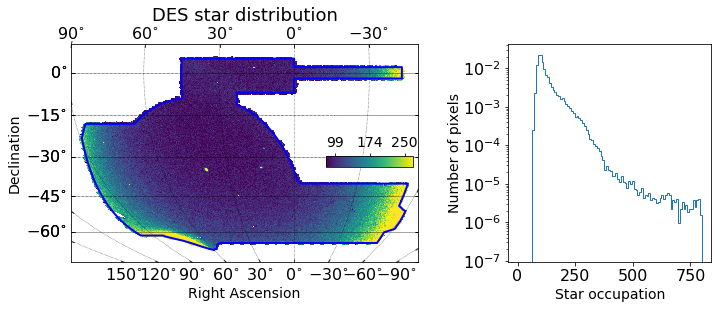

In [61]:
fig = plt.figure(figsize=(12.,4.))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
smap = DESSkymap()  
#smap.draw_hpxmap(nstars.byteswap().newbyteorder(),pix.byteswap().newbyteorder(),NSIDE,xsize=1000)
smap.draw_hpxmap(nstars,pix,NSIDE_deg,xsize=1000)
smap.draw_inset_colorbar(fontsize=14)
smap.draw_des()
plt.title('DES star distribution', fontsize = 18, y=1.08)
ax2 = plt.subplot(gs[1])
fig.add_subplot(ax2)
plt.sca(ax2)
plt.xlabel('Star occupation')
plt.ylabel('Number of pixels',labelpad=1)
n,b,p = plt.hist(nstars,normed=True,histtype='step',bins=100,range=[0,800],log=True)
plt.savefig(figsdir+'y3gold_stellar_distribution_sof0.png')